# Simple implementation of an RNN in PyTorch

In this notebook we implement and train a Recurrent Neural Network (RNN) in PyTorch. 
We closely follow the tutorial on [datahacker](https://datahacker.rs/011-pytorch-rnn-with-pytorch/).

## Set-up

Import the modules we will need:

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Create the dataset to be used:

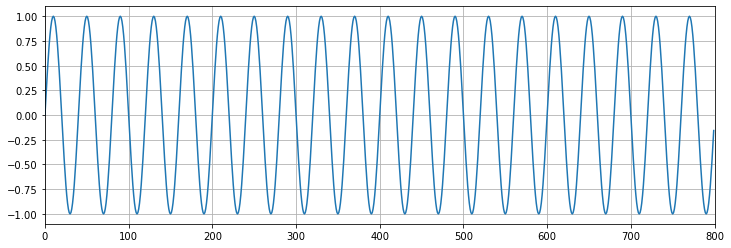

In [2]:
n_points = 800
period = 40

x = torch.linspace(0, n_points-1, n_points)
y = torch.sin(x * 2 * np.pi / period)

plt.figure(figsize=(12,4))
plt.xlim(0, n_points)
plt.grid()
plt.plot(y.numpy())
plt.show()

Split the data between a train set and a test set:

In [3]:
test_size = 40
train_set = y[:-test_size]
test_set = y[-test_size:]

Define the labeled train data:

In [4]:
window_size= 35
train_data = [(train_set[i:i+window_size],[train_set[i+window_size]]) 
              for i in range(0, len(train_set)-window_size)]

## Define the RNN model

Let us first define an LSTM layer class:

In [5]:
class myLSTM(nn.Module):
    
    def __init__(self, input_size=1, hidden_size=50, out_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size) # layer of LSTM cells
        self.linear = nn.Linear(hidden_size, out_size) # fully-connected layer
        # initialize the hidden parameters to 0
        self.hidden = (torch.zeros(1,1,hidden_size), torch.zeros(1,1,hidden_size)) 
        
    def forward(self, seq):
        lstm_out, self.hidden = self.lstm(seq.view(len(seq), 1, -1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq), -1))
        return pred[-1]

Instanciate the model:

In [6]:
learning_rate = 0.01

model = myLSTM()
criterion = nn.MSELoss() # mean square error loss function
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

print(model)
print("Parameters:")
for p in model.parameters():
  print(p.numel())

myLSTM(
  (lstm): LSTM(1, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)
Parameters:
200
10000
200
200
50
1


Train the model: 

In [7]:
epochs = 30
future = test_size # number of predictions

for i in range(epochs):
    
    # train for one epoch
    for seq, y_train in train_data:
        
        # set the gradients to 0
        optimizer.zero_grad()
        
        # reset the hidden variables
        model.hidden = (torch.zeros(1,1,model.hidden_size), 
                        torch.zeros(1,1,model.hidden_size))
        
        # make a prediction
        y_pred = model(seq)
        
        # compute the loss
        loss = criterion(y_pred, torch.tensor(y_train))
        
        # backpropagation
        loss.backward()
        
        # update the optimizer
        optimizer.step()
    
    print(f'Epoch {i+1}, Train loss: {loss.item()}, ', end='')
    
    # evaluate the model on the validation range
    preds = train_set.tolist()
    loss = 0
    for f in range(future):
        seq = torch.FloatTensor(preds[-window_size:])
        with torch.no_grad():
            model.hidden = (torch.zeros(1,1,model.hidden_size), 
                            torch.zeros(1,1,model.hidden_size))
            preds.append(model(seq).item())
            loss += criterion(torch.tensor(preds[-1]), test_set[f])
        loss /= future
    print(f'Validation loss: {loss} ')

Epoch 1, Train loss: 0.08723805844783783, Validation loss: 0.0006741642719134688 
Epoch 2, Train loss: 0.05127479508519173, Validation loss: 0.0001130985765485093 
Epoch 3, Train loss: 0.017697686329483986, Validation loss: 6.460578879341483e-05 
Epoch 4, Train loss: 0.0014180142898112535, Validation loss: 0.00514125544577837 
Epoch 5, Train loss: 7.040325726848096e-05, Validation loss: 0.0012061038287356496 
Epoch 6, Train loss: 2.2710517441737466e-05, Validation loss: 0.0003913672990165651 
Epoch 7, Train loss: 1.9655770302051678e-05, Validation loss: 0.0003024896723218262 
Epoch 8, Train loss: 1.937377055583056e-05, Validation loss: 0.0002709002874325961 
Epoch 9, Train loss: 1.9107093976344913e-05, Validation loss: 0.0002475985966157168 
Epoch 10, Train loss: 1.8667513359105214e-05, Validation loss: 0.00022778703714720905 
Epoch 11, Train loss: 1.8095741324941628e-05, Validation loss: 0.0002106976753566414 
Epoch 12, Train loss: 1.7438153008697554e-05, Validation loss: 0.0001958305

Visualize the results:

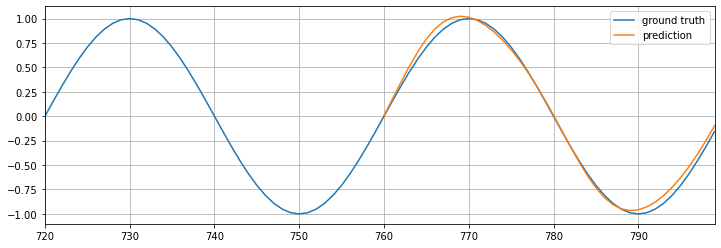

In [8]:
plt.figure(figsize=(12,4))
plt.xlim(n_points-2*period, n_points-1)
plt.grid()
plt.plot(y.numpy(), label='ground truth')
plt.plot(range(n_points-future, n_points), preds[-future:], label='prediction')
plt.legend()
plt.show()